In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib notebook
%matplotlib inline

In [2]:
G = nx.read_gpickle('email_prediction_NEW.txt', )

print(nx.info(G))

Graph with 1005 nodes and 16706 edges


C:\Users\rogha\AppData\Local\Temp\ipykernel_16192\1797801492.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


## New Connections Prediction

In [3]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


In [4]:
df = pd.DataFrame(index = nx.non_edges(G))
df.head()

""
"(0, 2)"
"(0, 3)"
"(0, 4)"
"(0, 7)"
"(0, 8)"


In [5]:
df['Jacc_coef'] = [i[2] for i in sorted(nx.jaccard_coefficient(G))]
df['Res_alloc'] = [i[2] for i in sorted(nx.resource_allocation_index(G))]
df['Pref_Attach'] = [i[2] for i in sorted(nx.preferential_attachment(G))]
df['Community_cn'] = [i[2] for i in sorted(nx.cn_soundarajan_hopcroft(G, community='Department'))]
df['Community_ra'] = [i[2] for i in sorted(nx.ra_index_soundarajan_hopcroft(G, community='Department'))]

df.head()

,Jacc_coef,Res_alloc,Pref_Attach,Community_cn,Community_ra
"(0, 2)",0.045802,0.055340,4180,6,0.0
"(0, 3)",0.027273,0.021388,3124,3,0.0
"(0, 4)",0.022222,0.021388,4224,3,0.0
"(0, 7)",0.036364,0.061668,3168,4,0.0
"(0, 8)",0.012821,0.011628,1628,1,0.0


In [6]:
df = pd.concat([df, future_connections.sort_index()], axis=1)

# Let's remove the rows with a missing future connection value
to_predict = df[df['Future Connection'].isnull()].drop('Future Connection', axis=1)
df.dropna(subset=['Future Connection'], inplace=True)

In [7]:
X = df.drop('Future Connection', axis=1)
y = df['Future Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Feature selection

Training score:  0.9177628832051297
Test score:  0.9050871008853077


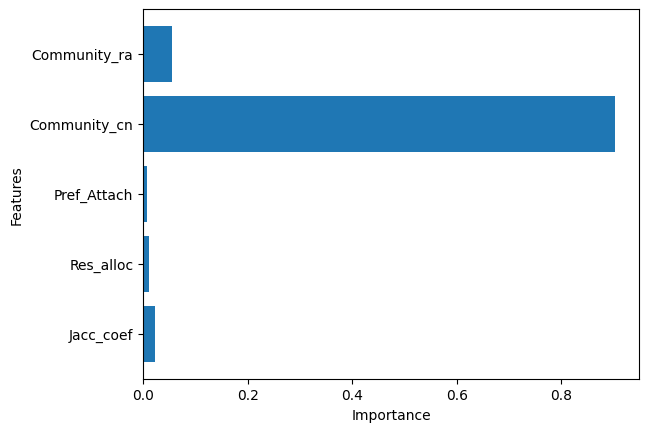

In [8]:
clf = DecisionTreeClassifier(max_depth=9).fit(X_train, y_train)

plt.figure()
plt.barh(np.arange(len(X.columns)), clf.feature_importances_)
plt.ylabel('Features')
plt.yticks(np.arange(len(X.columns)))
plt.gca().set_yticklabels(list(X.columns))
plt.xlabel('Importance')

print('Training score: ', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print('Test score: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

<AxesSubplot: >

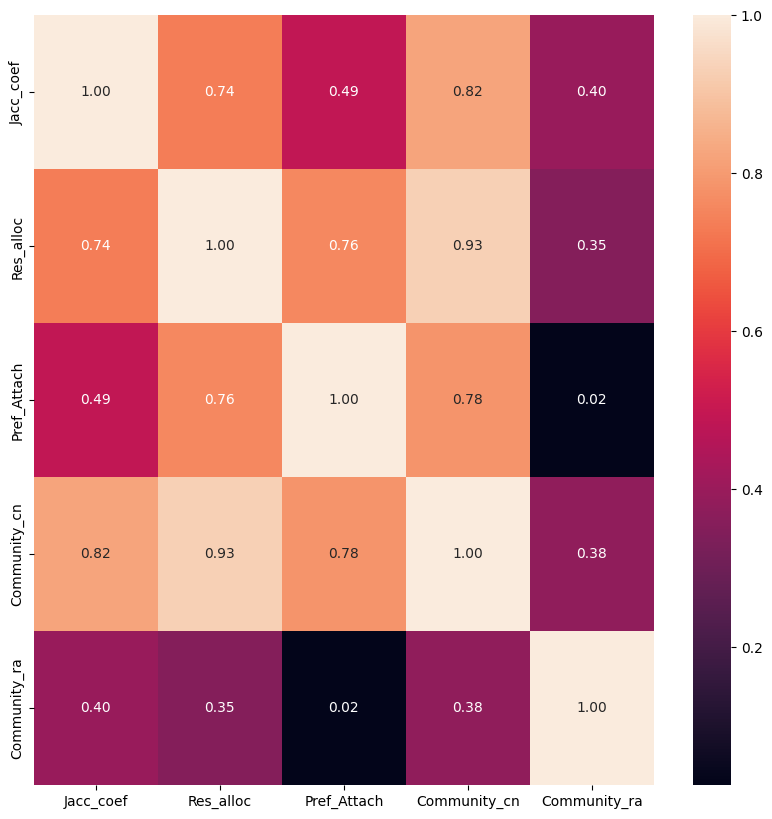

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')

In [10]:
X = df.drop(['Future Connection', 'Res_alloc', 'Jacc_coef', 'Pref_Attach'], axis=1)
y = df['Future Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

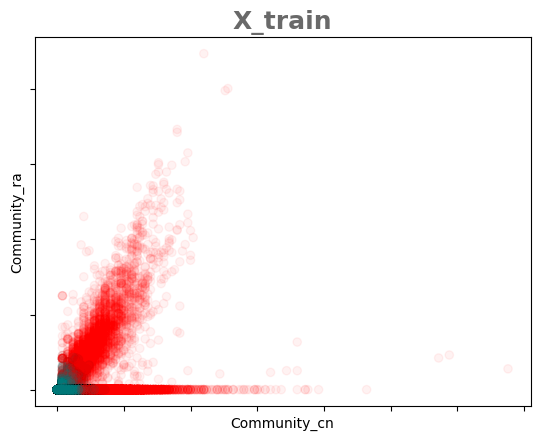

In [11]:
plt.figure()
plt.scatter(X_train['Community_cn'], X_train['Community_ra'], c=y_train.map({0: 'darkcyan', 1: 'red'}), alpha=0.05)

plt.title('X_train', fontsize=18, color='dimgrey', fontweight='bold')
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('Community_cn')
plt.ylabel('Community_ra');

In [12]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
clf = LogisticRegression()

grid_values = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300]}

grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring='roc_auc', cv=5)

grid_clf_auc.fit(X_train_scaled, y_train)

y_decision_fn_scores_auc = grid_clf_auc.predict_proba(X_test_scaled)[:,1]
y_decision_fn_train_scores_auc = grid_clf_auc.predict_proba(X_train_scaled)[:,1]

print('Grid best parameter (max. auc): ', grid_clf_auc.best_params_)
print('Grid best score (auc): ', grid_clf_auc.best_score_)

print('Train set auc score', roc_auc_score(y_train, y_decision_fn_train_scores_auc))
print('Test set auc score', roc_auc_score(y_test, y_decision_fn_scores_auc))
print(pd.DataFrame(grid_clf_auc.cv_results_))

Grid best parameter (max. auc):  {'C': 300}
Grid best score (auc):  0.9139970373207282
Train set auc score 0.9139991067140819
Test set auc score 0.9087072724624742
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.179491      0.011525         0.016135        0.001375   0.001   
1       0.203525      0.018119         0.013735        0.001370    0.01   
2       0.227461      0.011114         0.012658        0.001093     0.1   
3       0.276601      0.022918         0.012807        0.000843       1   
4       0.280008      0.019322         0.012659        0.000379      10   
5       0.296761      0.015313         0.012476        0.000783      50   
6       0.318935      0.040974         0.014940        0.002119     100   
7       0.434675      0.043381         0.021013        0.004162     200   
8       0.450708      0.039364         0.020479        0.006482     300   

         params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 

In [14]:
LR = LogisticRegression(C = 0.01).fit(X_train_scaled, y_train)
print('Train set auc score: ', roc_auc_score(y_train, LR.decision_function(X_train_scaled)))
print('Test set auc score: ', roc_auc_score(y_test, LR.decision_function(X_test_scaled)))

Train set auc score:  0.9137158528372662
Test set auc score:  0.9084449487112801


In [ ]:
clf = SVC(kernel='linear', C = 0.01).fit(X_train_scaled, y_train)
print('Train set auc score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test set auc score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))


In [15]:
to_predict['link_prediction'] = pd.Series(LR.predict(to_predict[['Community_cn', 'Community_ra']]),
                                          index=to_predict.index )

c:\Users\rogha\anaconda3\envs\sin\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [16]:
to_predict.groupby('link_prediction')['Community_cn'].mean()

link_prediction
0.0    0.000000
1.0    4.410645
Name: Community_cn, dtype: float64

In [17]:
to_predict[to_predict['Community_cn'] > 0]['link_prediction'].mean()

1.0